In [ ]:
from google.colab import drive 
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Colab Notebooks/

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from fbprophet import Prophet
from pandas import to_datetime
from pandas import DataFrame
from sklearn.metrics import mean_absolute_error
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics



In [ ]:


def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true)*100)


In [ ]:
#Reading the data

df = pd.read_csv('dublinbikes_20190101_20190401.csv' , parse_dates=['TIME'],index_col="TIME" )
#print(df.head(1))
df_bs = df[df['NAME'].str.contains('BLESSINGTON STREET')]
df_group = df_bs.groupby(['TIME']).sum()
df_group = df_group.drop(columns=['STATION ID', 'BIKE STANDS','AVAILABLE BIKE STANDS','LATITUDE','LONGITUDE'])
X1 = df_group.index
X2 = df_group.iloc[:,0]
#rcParams['figure.figsize'] = 22, 10



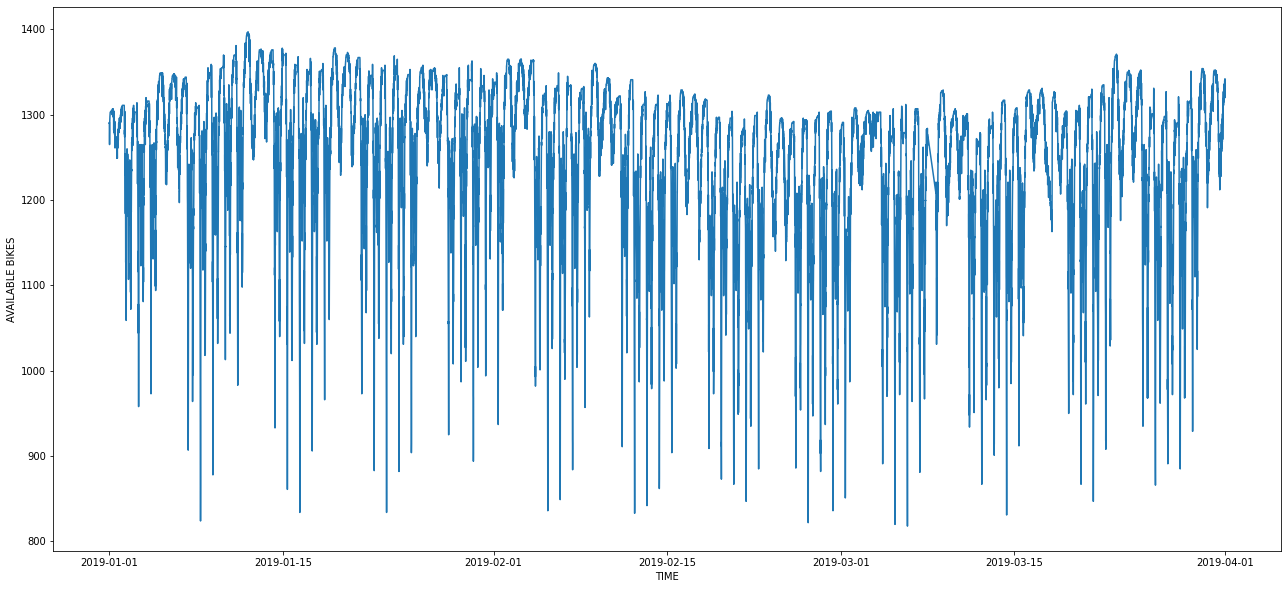

In [ ]:


#Plotting the training data
rcParams['figure.figsize'] = 22, 10
sns.lineplot(x=df_group.index, y=X2,data = df_group)


In [ ]:

#Preparing data to fit in the model; changing columns names to 'ds' and 'y'
df_input=df_group.copy()
df_input = df_input.rename(columns={'AVAILABLE BIKES': 'y'})
df_input.reset_index(inplace=True)
df_input = df_input.rename(columns = {'TIME':'ds'})
df_input.reset_index(drop=True, inplace=True)  #dropping the index column



In [ ]:
#Code block for cross validation of changepoint_prior_scale and seasonality_prior_scale. Do not run unless required

# import itertools
# param_grid = {  
#     'changepoint_prior_scale': [ 0.1, 1, 10, 30, 100],
#     'seasonality_prior_scale': [ 7, 30],
# }

# # Generate all combinations of parameters
# all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
# rmses = []  # Store the RMSEs for each params here

# # Use cross validation to evaluate all parameters
# for params in all_params:
#     model = Prophet(**params).fit(df_input)  # Fit model with given params
#     df_cv = cross_validation(model, initial = '43200 minutes', period='4320 minutes', horizon='4320 minutes', parallel="processes")
#     df_p = performance_metrics(df_cv, rolling_window=1)
#     rmses.append(df_p['rmse'].values[0])

# # Find the best parameters
# tuning_results = pd.DataFrame(all_params)
# tuning_results['rmse'] = rmses
# print(tuning_results)






INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
#preparing the final model

model = Prophet(changepoint_prior_scale=30, seasonality_mode="additive", seasonality_prior_scale = 30, daily_seasonality = False, weekly_seasonality=False)
model.add_seasonality(name='daily', period=1, fourier_order=15)
model.add_seasonality(name='weekly', period=7, fourier_order=20)
model.fit(df_input)


INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:


#Training the model on the first 43200 mintues (1month). It will forecast the next 4320 minutes of data (because horizon is set to 4320). 
#The model will then train on the initial period + the period (43200 + 1440 minutes in this case) and forecast the next 4320 minutes. 
#It will continued like this, adding another 120 minutes to the training data and then forecasting for the next 4320 until there is no longer enough data to do this.
#cv_results = cross_validation(model, initial = '43200 minutes', period='2880 minutes', horizon='4320 minutes', parallel="processes")
cv_results = cross_validation(model, horizon='23000 minutes')







INFO:fbprophet:Making 4 forecasts with cutoffs between 2019-02-20 01:35:03 and 2019-03-16 00:35:03


In [ ]:
mae_baseline= mean_absolute_percentage_error(cv_results.y, cv_results.yhat) 
print("The mean percentage error with cross validation is: ", mae_baseline)

The mean percentage error with cross validation is:  3.032158096666491


                   ds         yhat   yhat_lower   yhat_upper
0 2019-02-20 01:40:01  1284.392166  1237.915087  1332.983741
1 2019-02-20 01:45:02  1284.073089  1238.618363  1332.553162
2 2019-02-20 01:50:02  1283.771250  1239.423101  1329.580389
3 2019-02-20 01:55:01  1283.568325  1239.268192  1329.564200
4 2019-02-20 02:00:03  1283.528307  1237.608220  1325.911764


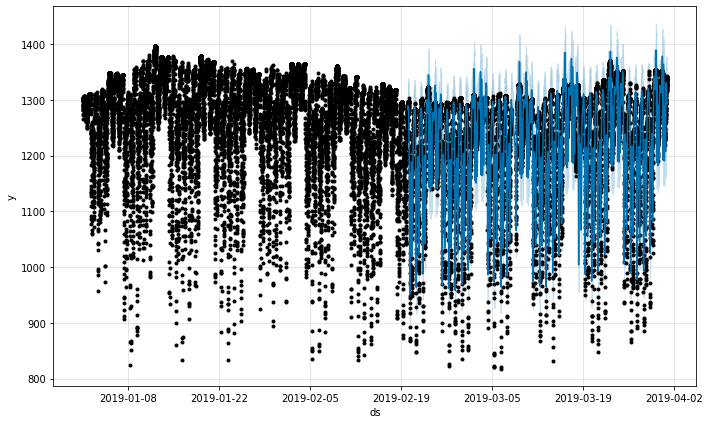

In [ ]:

forecast = model.predict(cv_results)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()) # summarize the forecast
model.plot(forecast)
plt.show()



           horizon          mse      rmse  ...      mape     mdape  coverage
0 15 days 23:20:00  2377.524948  48.75987  ...  0.030322  0.023813  0.943692

[1 rows x 7 columns]


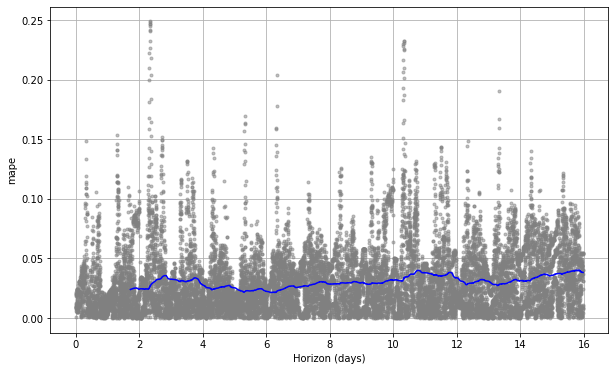

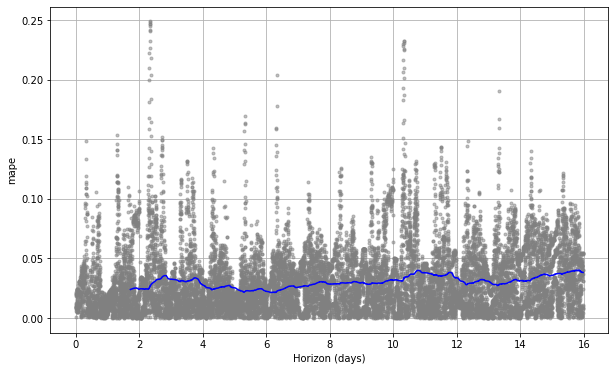

In [ ]:
#performance metrics

df_p = performance_metrics(cv_results, rolling_window=1)
print(df_p)

from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(cv_results, metric='mape')
fig



8731
[[1274]
 [1274]
 [1275]
 ...
 [1337]
 [1341]
 [1341]]
                      ds
0    2019-03-01 00:00:02
1    2019-03-01 00:05:02
2    2019-03-01 00:10:02
3    2019-03-01 00:15:02
4    2019-03-01 00:20:02
...                  ...
8726 2019-03-31 23:35:03
8727 2019-03-31 23:40:03
8728 2019-03-31 23:45:02
8729 2019-03-31 23:50:04
8730 2019-03-31 23:55:03

[8731 rows x 1 columns]
                   ds         yhat   yhat_lower   yhat_upper
0 2019-03-01 00:00:02  1281.669509  1235.173085  1328.117657
1 2019-03-01 00:05:02  1281.201030  1236.732435  1329.947551
2 2019-03-01 00:10:02  1280.827759  1236.127478  1325.551849
3 2019-03-01 00:15:02  1280.628625  1231.609522  1326.213107
4 2019-03-01 00:20:02  1280.667761  1230.435062  1325.842066


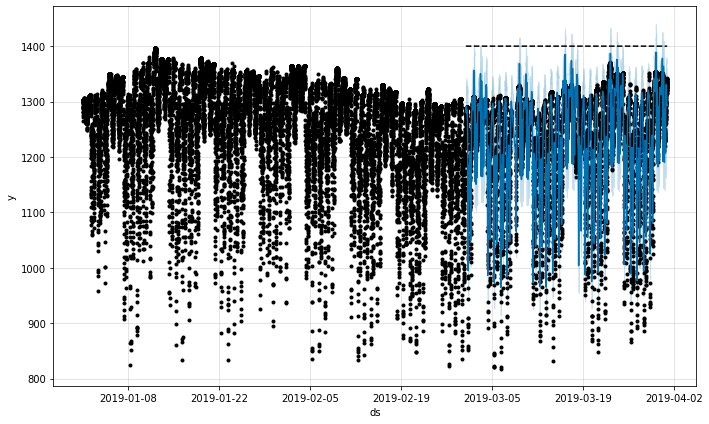

The mean error without cross validation is:  8.010591742806024


In [ ]:

#preparing validation set
time=np.array(df_input.iloc[:,0])
time=time.reshape(-1,1)

bikes=np.array(df_input.iloc[:,1])
bikes=bikes.reshape(-1,1)

time_x = np.zeros_like(time)
bikes_y = np.zeros_like(bikes)
df_input['ds']= to_datetime(df_input['ds'])
j=0
for i in range(len(time)):
    if '2019-03' in str(time[i]):   
        time_x[j] = time[i]
        bikes_y[j]=bikes[i]
        j=j+1

for i in range(len(time_x)):
    if '1970-01-01T00:00:00.000000000' in str(time_x[i]):
       print(i)
       break

j=len(time_x)-i
x=[];bikes_output=[]
x=time_x[:-j, :]
x=np.array(x).reshape(-1,1)

bikes_output=bikes_y[:-j, :]
bikes_output=np.array(bikes_output).reshape(-1,1)

print(bikes_output)

df_val=pd.DataFrame(x, columns=['ds']) 
print(df_val)

df_val['cap']=1400
df_val['floor']=800


#prediction on validation set without using cross validation

forecast = model.predict(df_val)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()) # summarize the forecast
model.plot(forecast)
plt.show()


mae_baseline= mean_absolute_percentage_error(bikes_output, forecast.yhat) 
print("The mean error without cross validation is: ", mae_baseline)


In [ ]:





#preparing unseen data for predictions

df = pd.read_csv('dublinbikes_20190401_20190701_test.csv' , parse_dates=['TIME'],index_col="TIME" )
df_test = df[df['NAME'].str.contains('BLESSINGTON STREET')]
df_test = df_test.groupby(['TIME']).sum()
df_test = df_test.drop(columns=['STATION ID', 'BIKE STANDS','AVAILABLE BIKE STANDS','LATITUDE','LONGITUDE'])

df_test.reset_index(inplace=True)
df_test = df_test.rename(columns = {'TIME':'ds'})
df_test.reset_index(drop=True, inplace=True)  #dropping the index column
print(df_test)

time_test=np.array(df_test.iloc[:,0])
time_test=time_test.reshape(-1,1)

bikes_test=np.array(df_test.iloc[:,1])
bikes_test=bikes_test.reshape(-1,1)

df_test = df_test.drop(columns=['AVAILABLE BIKES'])

time_x_test = np.zeros_like(time_test)
bikes_y_test = np.zeros_like(bikes_test)
df_test['ds']= to_datetime(df_test['ds'])
j=0
for i in range(len(time_test)):
    if '2019-04' in str(time_test[i]): 
        time_x_test[j] = time_test[i]
        bikes_y_test[j]=bikes_test[i]
        j=j+1

for i in range(len(time_test)):
    if '1970-01-01T00:00:00.000000000' in str(time_x_test[i]):
        print(i)
        break

  
j=len(time_x_test)-i
x=[];bikes_output_test=[]
x_test=time_x_test[:-j, :]
x_test=np.array(x_test).reshape(-1,1)
print("check here: ",len(x_test))

bikes_output_test=bikes_y_test[:-j, :]
bikes_output_test=np.array(bikes_output_test).reshape(-1,1)

df_test=pd.DataFrame(x_test, columns=['ds']) 
print(df_test)

df_test['cap']=30
df_test['floor']=0




                       ds  AVAILABLE BIKES
0     2019-04-01 00:00:06             1342
1     2019-04-01 00:05:04             1342
2     2019-04-01 00:10:04             1342
3     2019-04-01 00:15:03             1343
4     2019-04-01 00:20:03             1343
...                   ...              ...
20828 2019-06-12 08:10:02             1175
20829 2019-06-12 08:15:02             1185
20830 2019-06-12 08:20:02             1236
20831 2019-06-12 08:25:02             1254
20832 2019-06-12 08:30:03             1255

[20833 rows x 2 columns]
8639
check here:  8639
                      ds
0    2019-04-01 00:00:06
1    2019-04-01 00:05:04
2    2019-04-01 00:10:04
3    2019-04-01 00:15:03
4    2019-04-01 00:20:03
...                  ...
8634 2019-04-30 23:35:03
8635 2019-04-30 23:40:03
8636 2019-04-30 23:45:02
8637 2019-04-30 23:50:03
8638 2019-04-30 23:55:02

[8639 rows x 1 columns]


                   ds         yhat   yhat_lower   yhat_upper
0 2019-04-01 00:00:06  1294.319370  1247.347793  1341.987680
1 2019-04-01 00:05:04  1294.524925  1248.471386  1343.209456
2 2019-04-01 00:10:04  1294.973492  1245.446988  1339.629538
3 2019-04-01 00:15:03  1295.733082  1248.553837  1340.345239
4 2019-04-01 00:20:03  1296.865291  1252.772173  1343.275130


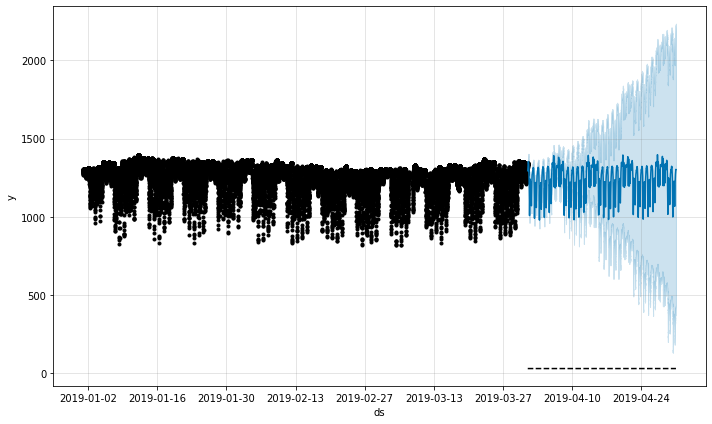

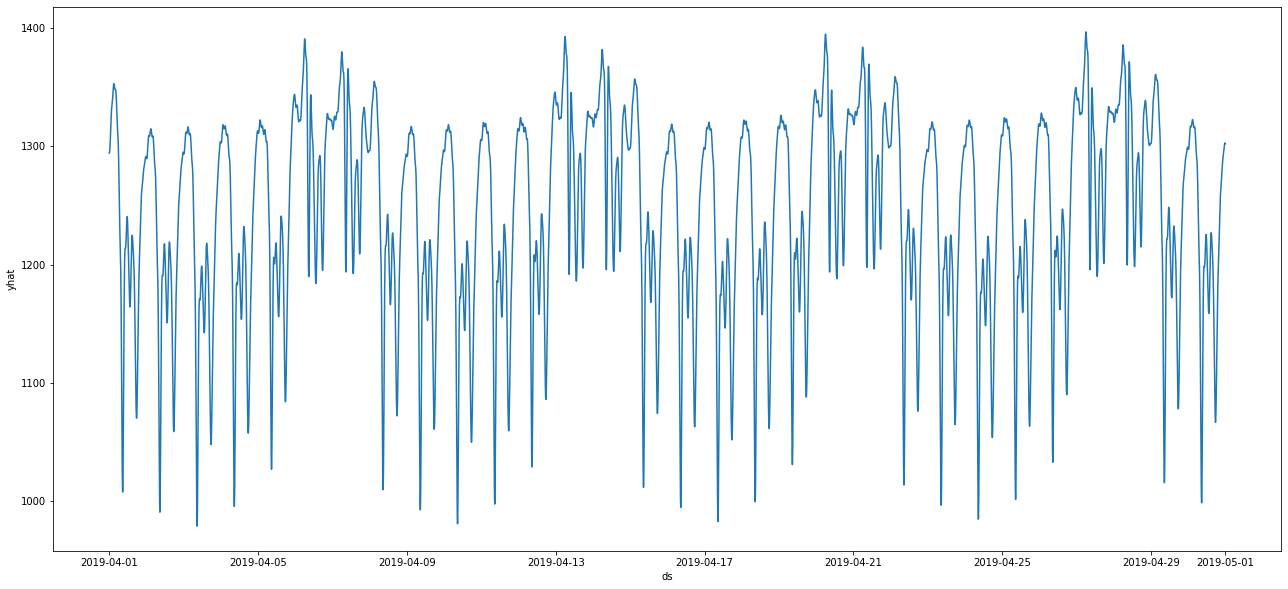

In [ ]:

#prediction on test data
forecast_test = model.predict(df_test)
print(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()) # summarize the forecast
model.plot(forecast_test)
plt.show()



sns.lineplot(x=df_test.ds, y=forecast_test.yhat, data = forecast_test)


8639
8639
8639
The difference is:             yhat
0    -47.680630
1    -47.475075
2    -47.026508
3    -47.266918
4    -46.134709
...         ...
8634 -28.237831
8635 -30.114813
8636 -35.191115
8637 -36.428469
8638 -36.764445

[8639 rows x 1 columns]
The mean percentage error is:  4.458834676757473


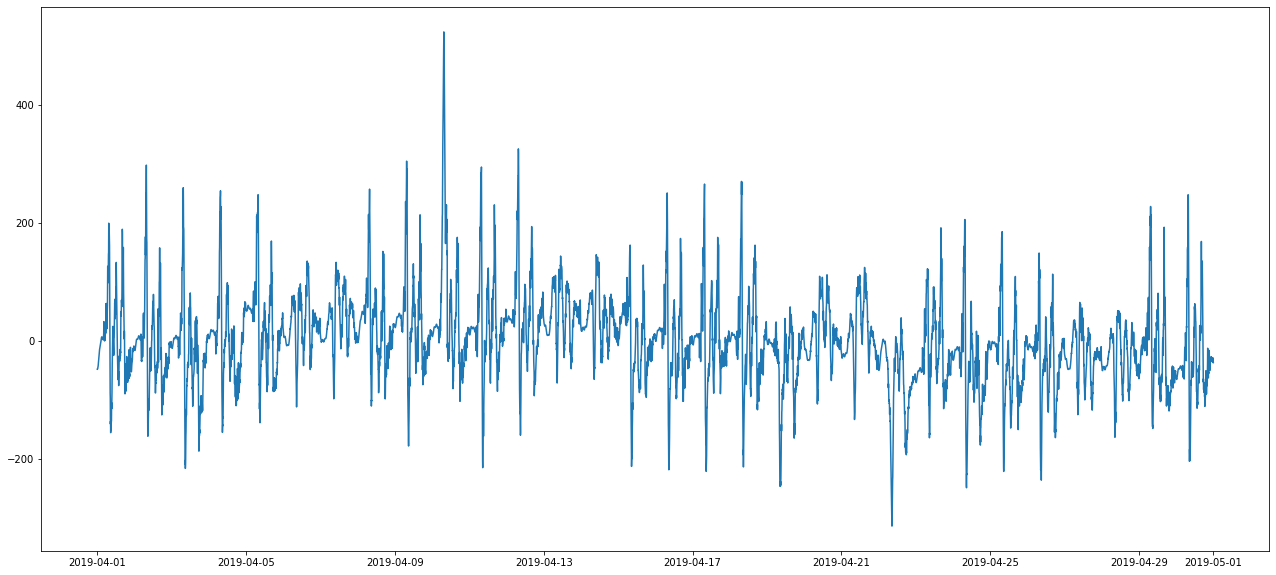

In [ ]:

#Plotting the error for test set predictions 
a=[]
a=forecast_test[['yhat']]
print(len(a))
b=[]  
b=bikes_output_test
print(len(b))
c=[]
c=a-b
print(len(c))
print("The difference is: ",c)
plt.plot (x_test,c)

mae= mean_absolute_percentage_error(b, a) 
print("The mean percentage error is: ", mae)